# **Estimating the drift capacity of RC Walls using Machine Learning**

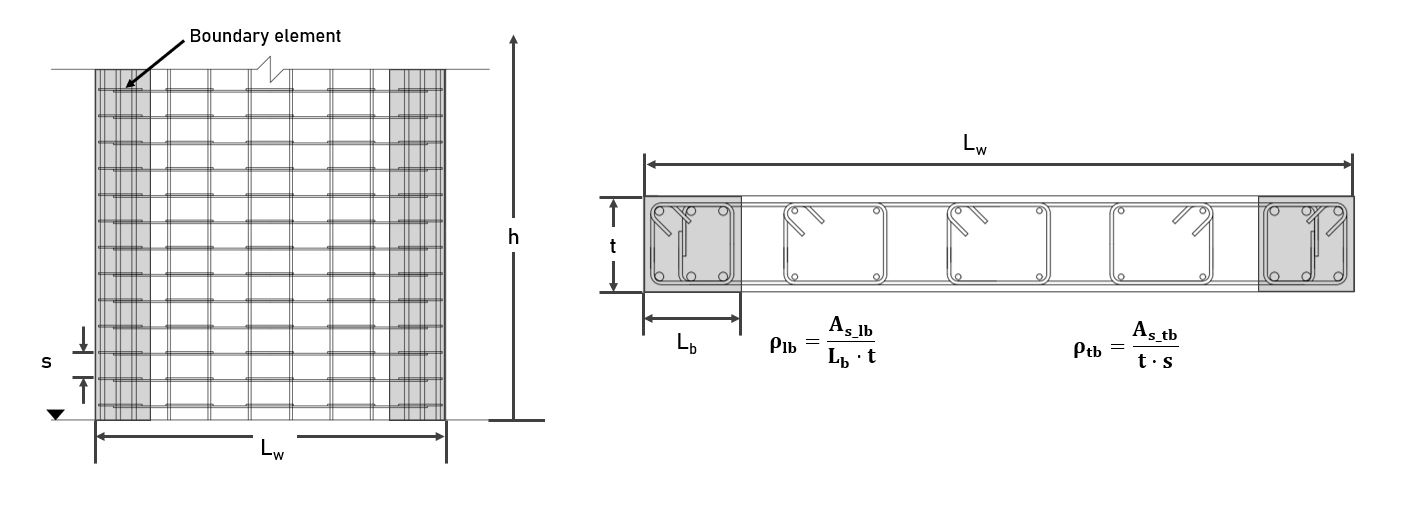

In [2]:
# @title Click the Play button to run the code.
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import lightgbm as lgb
from ipywidgets import *
from IPython.display import display, HTML
import gdown
from pickle import dump, load
import os


import gdown
# Load the data
file_id = '1RbtwLqQIgXK2chmut9A-oH5GpPGx7Ck_'
file_path = '/content/RC_Wall_Database.xlsx'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, file_path, quiet=True)

data = pd.read_excel(file_path)

# Prepare the data
params = data[['M/Vlw']].copy()
params['L/t'] = data["lw/tw"]
params["f'c"] = data["fc"]
params['t / h'] = data['tw'] / data['h']
params['s / h'] = data['s'] / data['h']
params['ρhb Fy'] = data['Fy,hc'] * data['ρhc'] * 100
params['ρvb Fy'] = data['Fy,vc'] * data['ρvc'] * 100
params['ALR'] = data['P/fcAg']

column_names = params.columns.tolist()
DC = data['DC'].values * 100

# Shuffle the data
params, DC = shuffle(params, DC, random_state=6)
features = params.values

# Function to pre-train the model
def pretrain_model():
    # Create a LightGBM dataset for training
    train_data = lgb.Dataset(features, label=DC)

    # Define hyperparameters for the LightGBM model
    params = {
        'boosting_type': 'gbdt',
        'metric': 'binary_logloss',
        'max_bin': 50,
        'learning_rate': 0.0075,
        'feature_fraction': 0.4,
    }

    # Turn off warning messages (set logging level to 'silent')
    params['verbose'] = -1

    # Train the LightGBM model
    num_round = 5000
    bst = lgb.train(params, train_data, num_round)
    return bst

# Function to load the pre-trained model
def load_pretrained_model():
    fl = 'pretrained_model.pkl'
    if os.path.isfile(fl):
        with open(fl, 'rb') as fp:
            bst = load(fp)
    else:
        bst = pretrain_model()
        with open(fl, 'wb') as fp:
            dump(bst, fp)
    return bst

# Function to calculate the drift capacity
def _drift_calculator(fc, Lw, t, h, s, rholb, rhotb, Fy, ALR, bst):
    input_data = np.array([[h/Lw, Lw/t, fc, t/h, s/h, rholb*Fy, rhotb*Fy, ALR]], dtype=float)
    y_pred = bst.predict(input_data)

    # Output the estimated drift capacity
    display(HTML(f"<p style='font-size:24px; font-weight:bold; font-family:Bahnschrift;'>Estimated Drift Capacity: {y_pred[0]:.2f} %</p>"))

# Custom CSS to style the sliders
custom_css = """
<style>
    .widget-label {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-hbox .widget-label {
        min-width: 530px;
    }
    .widget-slider .slider, .widget-slider .slider-value {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-slider .slider-readout {
        font-family: Bahnschrift;
        font-size: 18px;
    }
    .widget-readout {
        font-family: Bahnschrift;
        font-size: 18px;
    }
</style>
"""

# Function to create interactive widgets
def drift_calculator():
    bst = load_pretrained_model()

    # Create sliders with descriptions and layout adjustments
    sliders = [
        ("f'c (MPa) - Compressive strength of concrete", 30, 20, 100, 1, "0.0f"),
        ("Lw (mm) - Wall length", 3000, 1000, 12000, 100, "0.0f"),
        ("t (mm) - Wall thickness", 300, 50, 1000, 10, "0.0f"),
        ("h (mm) - Wall height", 3000, 1000, 50000, 100, "0.0f"),
        ("s (mm) - Spacing of stirrups in boundary", 100, 10, 300, 10, "0.0f"),
        ("ρlb (%) - Longitudinal reinforcement ratio of boundary element", 2.0, 0.0, 5.0, 0.1, "0.1f"),
        ("ρtb (%) - Transverse reinforcement ratio of boundary element", 0.4, 0.0, 5.0, 0.1, "0.1f"),
        ("Fy (MPa) - Yield strength of reinforcement", 500, 300, 1000, 10, "0.0f"),
        ("ALR - Axial load ratio", 0.2, 0.0, 0.4, 0.01, "0.2f")
    ]

    slider_widgets = []
    for desc, val, min_val, max_val, step, fmt in sliders:
        slider = FloatSlider(value=val, min=min_val, max=max_val, step=step, continuous_update=True, layout=Layout(width='400px'), style={'description_width': 'initial'}, readout_format=fmt)
        label = Label(desc, layout=Layout(width='300px'))
        slider_widgets.append(HBox([label, slider]))

    # Interactive output widget
    io = interactive_output(_drift_calculator, {
        'fc': slider_widgets[0].children[1], 'Lw': slider_widgets[1].children[1], 't': slider_widgets[2].children[1],
        'h': slider_widgets[3].children[1], 's': slider_widgets[4].children[1], 'rholb': slider_widgets[5].children[1],
        'rhotb': slider_widgets[6].children[1], 'Fy': slider_widgets[7].children[1], 'ALR': slider_widgets[8].children[1],
        'bst': fixed(bst)
    })

    # Inject custom CSS
    display(HTML(custom_css))

    # Display widgets
    display(VBox(slider_widgets + [io]))

# Run the interactive drift calculator
drift_calculator()


This repository uses existing data of RC Walls subjected to cyclic loading to train a Gradient-Boosted Decision Tree (GBDT) machine learning algorithm to estimate drift capacity. Drift capacity is defined as the drift measured at a 20% loss in lateral resistance. The algorithm is trained using a dataset of 429 RC Wall tests

Please get in touch if you would like to share more tests not currently included in the repository.

Here is a link to the existing databse of RC Walls : https://docs.google.com/spreadsheets/d/1RbtwLqQIgXK2chmut9A-oH5GpPGx7Ck_/edit?usp=sharing&ouid=116207180103751625935&rtpof=true&sd=true



### **Results from K-fold cross validation of the database of RC Walls is shown below**

---

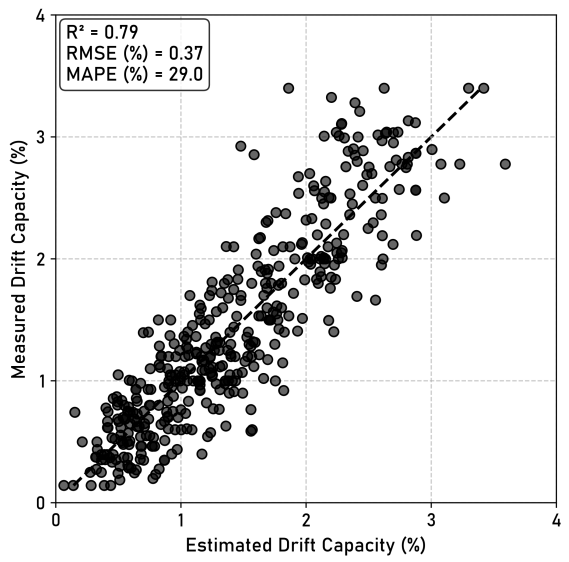